In [1]:
import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../')

import read_trace
import cuda_timeline
from avgblkmodel import *
import cke
#from model_cke import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# gpu info

In [2]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

# 2 stream info

In [3]:
# 10M for mem_mem : where the h2d between streams are overlapped
trace_file = 'trace_10M_s1.csv'
trace_file_2cke = 'trace_h2d_h2d_ovlp.csv'


df_trace = read_trace.trace2dataframe(trace_file) # read the trace to the dataframe
df_trace_2cke = read_trace.trace2dataframe(trace_file_2cke)

In [4]:
df_trace

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,Device,Context,Stream,Name
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN
1,610.840271,6.436815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,5.787475,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
2,617.278302,6.429999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,5.793609,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
3,623.719789,1.276618,39063.0,1.0,1.0,256.0,1.0,1.0,8.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,13.0,"kernel_vectorAdd(float const *, float const *,..."
4,625.003191,6.269646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,5.941787,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy DtoH]


/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


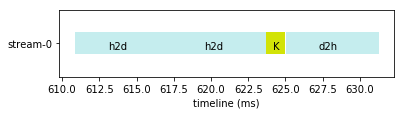

In [5]:
cuda_timeline.plot_trace(df_trace)

In [6]:
df_trace_2cke

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,Device,Context,Stream,Name
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN
1,665.032627,10.783099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,3.454749,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
2,668.190628,12.898855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,2.888078,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy HtoD]
3,675.816942,12.913127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,2.884886,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
4,681.090667,10.213144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,3.647545,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy HtoD]
5,688.741397,1.377896,39063.0,1.0,1.0,256.0,1.0,1.0,8.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,13.0,"kernel_vectorAdd(float const *, float const *,..."
6,690.126461,10.658490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,3.495139,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy DtoH]
7,691.316867,1.366120,39063.0,1.0,1.0,256.0,1.0,1.0,8.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,14.0,"kernel_vectorAdd(float const *, float const *,..."
8,693.294222,9.522868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.146973,3.911942,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy DtoH]


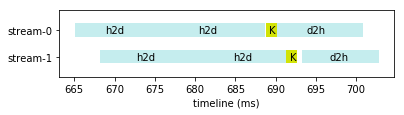

In [7]:
cuda_timeline.plot_trace(df_trace_2cke)

# 1cke - read trace and reset the timeline

In [8]:
df_single_stream = read_trace.get_timing(df_trace)

In [9]:
df_single_stream

,stream,api_type,start,end,size,duration
0,0.0,h2d,610.840271,617.277086,38146.973,6.436815
1,0.0,h2d,617.278302,623.708301,38146.973,6.429999
2,0.0,kern,623.719789,624.996407,0.000,1.276618
3,0.0,d2h,625.003191,631.272837,38146.973,6.269646


In [10]:
df_s1 = read_trace.reset_starting(df_single_stream)

In [11]:
df_s1

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,6.436815,38146.973,6.436815
1,0.0,h2d,6.438031,12.868030,38146.973,6.429999
2,0.0,kern,12.879518,14.156136,0.000,1.276618
3,0.0,d2h,14.162920,20.432566,38146.973,6.269646


### 2cke case

In [12]:
df_2stream = read_trace.get_timing(df_trace_2cke)

In [13]:
df_2stream

,stream,api_type,start,end,size,duration
0,0.0,h2d,665.032627,675.815726,38146.973,10.783099
1,0.0,h2d,675.816942,688.730069,38146.973,12.913127
2,0.0,kern,688.741397,690.119293,0.000,1.377896
3,0.0,d2h,690.126461,700.784951,38146.973,10.658490
4,1.0,h2d,668.190628,681.089483,38146.973,12.898855
5,1.0,h2d,681.090667,691.303811,38146.973,10.213144
6,1.0,kern,691.316867,692.682987,0.000,1.366120
7,1.0,d2h,693.294222,702.817090,38146.973,9.522868


In [14]:
tot_runtime = read_trace.getTotalRuntime(df_2stream)
print tot_runtime

37.784463


# 2 cke

In [15]:
stream_num = 2
df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num)

In [16]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,6.436815,38146.973,6.436815
1,0,h2d,6.438031,12.868030,38146.973,6.429999
2,0,kern,12.879518,14.156136,0.000,1.276618
3,0,d2h,14.162920,20.432566,38146.973,6.269646


In [17]:
#df_cke_list[1]

In [18]:
# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

for i in range(1,stream_num):
    # compute the time for the init data transfer
    stream_startTime = cke.find_h2d_start(df_cke_list[i-1], H2D_H2D_OVLP_TH)
    print('stream_startTime : {}'.format(stream_startTime))
    df_cke_list[i].start += stream_startTime
    df_cke_list[i].end   += stream_startTime

stream_startTime : 3.158431


In [19]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,6.436815,38146.973,6.436815
1,0,h2d,6.438031,12.868030,38146.973,6.429999
2,0,kern,12.879518,14.156136,0.000,1.276618
3,0,d2h,14.162920,20.432566,38146.973,6.269646


In [20]:
df_cke_list[1]

,stream,api_type,start,end,size,duration
0,1,h2d,3.158431,9.595246,38146.973,6.436815
1,1,h2d,9.596462,16.026461,38146.973,6.429999
2,1,kern,16.037949,17.314567,0.000,1.276618
3,1,d2h,17.321351,23.590997,38146.973,6.269646


In [21]:
# streams_api_status = []
# for i in range(stream_num):
#     current_s = df_cke_list[i]
#     #print current_s.shape
#     local_api_status = []
#     api_num = current_s.shape[0]
#     for j in range(api_num):
#         local_api_status.append([current_s['api_type'][j], 'none']) 
    
#     # append the current api trace to the entire api status
#     streams_api_status.append(local_api_status)

In [22]:
# streams_api_timing = []
# for i in range(stream_num):
#     current_s = df_cke_list[i]
#     #print current_s.shape
#     local_api_tming = []
#     api_num = current_s.shape[0]
#     for j in range(api_num):
#         local_api_tming.append([current_s['start'][j], current_s['end'][j] ]) 
    
#     # append the current api trace to the entire api status
#     streams_api_timing.append(local_api_tming)

In [23]:
df_all_api = cke.init_sort_api(df_cke_list)
print df_all_api

       start        end api_type    size_kb  stream_id status           bw
0   0.000000   6.436815      h2d  38146.973        0.0  sleep  5926.373991
4   3.158431   9.595246      h2d  38146.973        1.0  sleep  5926.373991
1   6.438031  12.868030      h2d  38146.973        0.0  sleep  5932.656133
5   9.596462  16.026461      h2d  38146.973        1.0  sleep  5932.656133
2  12.879518  14.156136     kern      0.000        0.0  sleep     0.000000
3  14.162920  20.432566      d2h  38146.973        0.0  sleep  6084.390251
6  16.037949  17.314567     kern      0.000        1.0  sleep     0.000000
7  17.321351  23.590997      d2h  38146.973        1.0  sleep  6084.390251


In [24]:
df_all_api['bytes_done'] = 0.0
df_all_api['bytes_left'] = df_all_api['size_kb']

In [25]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left
0,0.000000,6.436815,h2d,38146.973,0.0,sleep,5926.373991,0.0,0.0
4,3.158431,9.595246,h2d,38146.973,1.0,sleep,5926.373991,0.0,0.0
1,6.438031,12.868030,h2d,38146.973,0.0,sleep,5932.656133,0.0,0.0
5,9.596462,16.026461,h2d,38146.973,1.0,sleep,5932.656133,0.0,0.0
2,12.879518,14.156136,kern,0.000,0.0,sleep,0.000000,0.0,0.0
3,14.162920,20.432566,d2h,38146.973,0.0,sleep,6084.390251,0.0,0.0
6,16.037949,17.314567,kern,0.000,1.0,sleep,0.000000,0.0,0.0
7,17.321351,23.590997,d2h,38146.973,1.0,sleep,6084.390251,0.0,0.0


In [26]:
# print df_all_api.iloc[0]
# print df_all_api.iloc[1]

In [42]:
#print df_all_api.shape[0]

curapi = df_all_api.iloc[0]['api_type']
curapi_start = df_all_api.iloc[0]['start']
curapi_end = df_all_api.iloc[0]['end']
curapi_stream = df_all_api.iloc[0]['stream_id']
# print(curapi_stream)
df_all_api.iloc[0, df_all_api.columns.get_loc('status')]  = 'wake' # set value without indexing




# find the next api info, if it is from the same stream, there is non ovlp
nextapi = df_all_api.iloc[1]['api_type']
nextapi_start = df_all_api.iloc[1]['start']
nextapi_end = df_all_api.iloc[1]['end']
nextapi_stream = df_all_api.iloc[1]['stream_id']
# print(nextapi_stream)

cnt_curr_stream = 0
check_coming_stream  = 0

if curapi_stream == nextapi_stream:
    print('cont next api for current stream')
    cnt_curr_stream = 1
else:
    print('check the api for the coming stream')
    check_coming_stream = 1

#----------------------
run_h2d_mod = 0
run_ker_mod = 0
run_d2h_mod = 0

if check_coming_stream:
    if curapi == 'h2d' and nextapi == 'h2d':
        print('h2d_h2d')
        run_h2d_mod = 1
    if curapi == 'kern' and nextapi == 'kern':
        print('kern_kern')
        run_ker_mod = 1
    if curapi == 'd2h' and nextapi == 'd2h':
        run_d2h_mod = 1
        print('d2h_d2h')
        
if run_h2d_mod == 1:
    no_ovlap_time = nextapi_start - curapi_start
    # use the org bw to transfer
    curr_trans = df_all_api.iloc[0]['bw'] * no_ovlap_time
    print curr_trans
    
    # update the bytes_done
    df_all_api.iloc[0, df_all_api.columns.get_loc('bytes_done')]  = curr_trans
    df_all_api.iloc[0, df_all_api.columns.get_loc('bytes_left')]  = df_all_api.iloc[0]['size_kb'] - curr_trans
    
    # from nextapi_start, there is 2-way h2d concurrency
    cc = 2
    
    df_all_api.iloc[1, df_all_api.columns.get_loc('status')] = 'wake'
    
    # predict with current concurrency for both api
    

check the api for the coming stream
h2d_h2d
18718.0433303


In [43]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left
0,0.000000,6.436815,h2d,38146.973,0.0,wake,5926.373991,18718.04333,19428.92967
4,3.158431,9.595246,h2d,38146.973,1.0,wake,5926.373991,0.00000,0.00000
1,6.438031,12.868030,h2d,38146.973,0.0,sleep,5932.656133,0.00000,0.00000
5,9.596462,16.026461,h2d,38146.973,1.0,sleep,5932.656133,0.00000,0.00000
2,12.879518,14.156136,kern,0.000,0.0,sleep,0.000000,0.00000,0.00000
3,14.162920,20.432566,d2h,38146.973,0.0,sleep,6084.390251,0.00000,0.00000
6,16.037949,17.314567,kern,0.000,1.0,sleep,0.000000,0.00000,0.00000
7,17.321351,23.590997,d2h,38146.973,1.0,sleep,6084.390251,0.00000,0.00000


# 3cke

In [29]:
stream_num = 3

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num)

In [30]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,6.436815,38146.973,6.436815
1,0,h2d,6.438031,12.868030,38146.973,6.429999
2,0,kern,12.879518,14.156136,0.000,1.276618
3,0,d2h,14.162920,20.432566,38146.973,6.269646


In [31]:
df_cke_list[1]

,stream,api_type,start,end,size,duration
0,1,h2d,0.000000,6.436815,38146.973,6.436815
1,1,h2d,6.438031,12.868030,38146.973,6.429999
2,1,kern,12.879518,14.156136,0.000,1.276618
3,1,d2h,14.162920,20.432566,38146.973,6.269646


In [32]:
df_cke_list[2]

,stream,api_type,start,end,size,duration
0,2,h2d,0.000000,6.436815,38146.973,6.436815
1,2,h2d,6.438031,12.868030,38146.973,6.429999
2,2,kern,12.879518,14.156136,0.000,1.276618
3,2,d2h,14.162920,20.432566,38146.973,6.269646


In [33]:
# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

for i in range(1,stream_num):
    # compute the time for the init data transfer
    stream_startTime = cke.find_h2d_start(df_cke_list[i-1], H2D_H2D_OVLP_TH)
    print('stream_startTime : {}'.format(stream_startTime))
    df_cke_list[i].start += stream_startTime
    df_cke_list[i].end   += stream_startTime

stream_startTime : 3.158431
stream_startTime : 6.316862


In [34]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,6.436815,38146.973,6.436815
1,0,h2d,6.438031,12.868030,38146.973,6.429999
2,0,kern,12.879518,14.156136,0.000,1.276618
3,0,d2h,14.162920,20.432566,38146.973,6.269646


In [35]:
df_cke_list[1]

,stream,api_type,start,end,size,duration
0,1,h2d,3.158431,9.595246,38146.973,6.436815
1,1,h2d,9.596462,16.026461,38146.973,6.429999
2,1,kern,16.037949,17.314567,0.000,1.276618
3,1,d2h,17.321351,23.590997,38146.973,6.269646


In [36]:
df_cke_list[2]

,stream,api_type,start,end,size,duration
0,2,h2d,6.316862,12.753677,38146.973,6.436815
1,2,h2d,12.754893,19.184892,38146.973,6.429999
2,2,kern,19.196380,20.472998,0.000,1.276618
3,2,d2h,20.479782,26.749428,38146.973,6.269646


# plot all the stream timeline

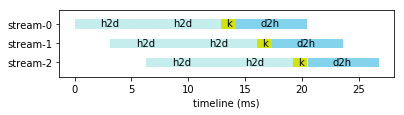

In [37]:
cuda_timeline.plot_cke_list(df_cke_list, savefig=True)

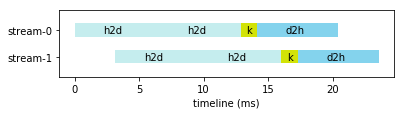

In [38]:
cuda_timeline.plot_cke_list(df_cke_list[0:2])

In [39]:
tot_runtime = read_trace.getTotalRuntime(df_cke_list[0:2])
print tot_runtime

20.432566


# Check the h2d overlapping

In [40]:
# # extract kernel info
# streaminfo = get_stream_info(df_trace)
# current_kern_info = streaminfo[0].kernel_info[0]

# grid_dim = float(current_kern_info.grid_x) * float(current_kern_info.grid_y) * float(current_kern_info.grid_z)
# block_dim = float(current_kern_info.blk_x) * float(current_kern_info.blk_y) * float(current_kern_info.blk_z)
# reg_per_thread = float(current_kern_info.regs_per_thread)
# sm_per_blk = float(current_kern_info.sm_per_block)
    
# # kernel runtime in ms
# current_kern =  streaminfo[0].kernel[0]
# kern_runtime_ms = float(current_kern.end_time_ms) - float(current_kern.start_time_ms)

# kernel = KernelInfo()
# kernel.blockDim = block_dim
# kernel.gridDim = grid_dim
# kernel.reg_per_thread = reg_per_thread
# kernel.sharedmem_per_blk = sm_per_blk
# kernel.runtime_ms = kern_runtime_ms

# kernel.avg_blk_time = compute_avgblktime(gtx950, kernel)
# #print kernel_avg_blk_time

### check whether there is h2d overlapping

In [41]:
prev_stm_h2ds_start, prev_stm_h2ds_end = find_h2ds_timing(df_cke_list[0])
print("prev stream h2ds : {} - {}".format(prev_stm_h2ds_start, prev_stm_h2ds_end))

curr_stm_h2ds_start, curr_stm_h2ds_end = find_h2ds_timing(df_cke_list[1])
print("curr stream h2ds : {} - {}".format(curr_stm_h2ds_start, curr_stm_h2ds_end))

NameError: name 'find_h2ds_timing' is not defined

In [ ]:
if curr_stm_h2ds_start >=prev_stm_h2ds_start and curr_stm_h2ds_start < prev_stm_h2ds_end:
    h2ds_ovlp_between_stream = True 
else:
    h2ds_ovlp_between_stream = False

print("h2ds_ovlp_between_stream : {}".format(h2ds_ovlp_between_stream))

### check kernel overlapping

In [ ]:
prev_stm_kern_start, prev_stm_kern_end = find_kern_timing(df_cke_list[0])
print("prev stream kern : {} - {}".format(prev_stm_kern_start, prev_stm_kern_end))

curr_stm_kern_start, curr_stm_kern_end = find_kern_timing(df_cke_list[1])
print("curr stream kern : {} - {}".format(curr_stm_kern_start, curr_stm_kern_end))


In [ ]:
if  prev_stm_kern_start <= curr_stm_kern_start < prev_stm_kern_end:
    kern_ovlp_between_stream = True 
else:
    kern_ovlp_between_stream = False

print("kern_ovlp_between_stream : {}".format(kern_ovlp_between_stream))

#### use cke model if kern_ovlp_between_stream is true

In [ ]:
# get the overlapping kernel info from both stream

# since the ovlp kernels are identical, we duplicate twice
kernel_num = 2
kernels = [kernel for i in range(kernel_num)]

pred_cke_time, kernels_start_end = model_cke_from_same_kernel(gtx950, kernels)

In [ ]:
pred_cke_time

In [ ]:
kernels_start_end

In [ ]:
df_cke_list[0]

In [ ]:
df_cke_list[1]

In [ ]:
def api_order(df_trace):
    order_ls = []
    for index,row in df_trace.iterrows():
        order_ls.append([str(row.api_type), index])
    return order_ls

In [ ]:
cke1_api_list = api_order(df_cke_list[1])
print cke1_api_list

In [ ]:
def find_api_pos(ls, api_name, order):
    count = 0
    index = 0
    found = 0
    for api in ls:
        if api[0] == api_name:
            count = count + 1
            if count == order:
                found = 1
                index = api[1]
                break;
    return found, index

In [ ]:
# found, pos = find_api_pos(cke1_api_list, "kern", 1)
# print("found : {}, pos : {}".format(found, pos))

In [ ]:
# adjust kernel timing 

df_current = df_cke_list[1]
df_current_kern = df_current.loc[df_current.api_type == "kern"]
#print df_current_kern.start
#print df_current_kern.end

df_prev = df_cke_list[0]
df_prev_kern = df_prev.loc[df_prev.api_type == "kern"]
#print df_prev_kern.start

kern_start_update =  float(df_prev_kern.start) + kernels_start_end[1][0]
print kern_start_update

kern_end_update = float(df_prev_kern.start) + kernels_start_end[1][1]
print kern_end_update

# we need to adjust the timing for the following api calls too
# find out the kern_d2h ovhd
df_current_d2h = df_current.loc[df_current.api_type == "d2h"]
#print df_current_d2h.start
#print df_current_kern.end

kern_d2h_ovhd = float(df_current_d2h.start) - float(df_current_kern.end)
print kern_d2h_ovhd


d2h_new_start = kern_end_update + kern_d2h_ovhd
print d2h_new_start

d2h_delta = d2h_new_start - float(df_current_d2h.start)
print d2h_delta

### update
found, pos = find_api_pos(cke1_api_list, "kern", 1)  # find the 1st kern in the api list
print("found : {}, pos : {}".format(found, pos))

df_current.set_value(pos, 'start', kern_start_update)
df_current.set_value(pos, 'end', kern_end_update)
df_current.set_value(pos, 'duration', kern_end_update - kern_start_update)
#df_current_kern.start = kern_start_update 
#df_current_kern.end = kern_end_update
#df_current_kern.duration = kern_end_update - kern_start_update


found, pos = find_api_pos(cke1_api_list, "d2h", 1)  # find the 1st kern in the api list
print("found : {}, pos : {}".format(found, pos))

df_current.set_value(pos, 'start', d2h_new_start)
df_current.set_value(pos, 'end', df_current_d2h.end + d2h_delta)
#df_current_d2h.start = d2h_new_start
#df_current_d2h.end = df_current_d2h.end + d2h_delta

In [ ]:
df_cke_list[0]

In [ ]:
df_cke_list[1]

### check whether d2h overlap

In [ ]:
prev_stm_d2h_start, prev_stm_d2h_end = find_d2h_timing(df_cke_list[0])
print("prev stream d2h : {} - {}".format(prev_stm_d2h_start, prev_stm_d2h_end))

curr_stm_d2h_start, curr_stm_d2h_end = find_d2h_timing(df_cke_list[1])
print("curr stream d2h : {} - {}".format(curr_stm_d2h_start, curr_stm_d2h_end))

In [ ]:
if  prev_stm_d2h_start <= curr_stm_d2h_start < prev_stm_d2h_end:
    d2h_ovlp_between_stream = True 
else:
    d2h_ovlp_between_stream = False

print("d2h_ovlp_between_stream : {}".format(d2h_ovlp_between_stream))